In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [2]:
# === STEP 2: Load and Filter Dataset (Unbalanced) ===
#DATA_DIR = r'D:\NIH Xray Dataset'
DATA_DIR = r'C:\Downloads\NIH Xray Dataset'
CSV_PATH = os.path.join(DATA_DIR, 'Data_Entry_2017.csv')
IMG_SIZE = 128
target_classes = ['Atelectasis', 'Consolidation', 'Effusion', 'Mass', 'No Finding']

In [3]:
def preprocess_image(file_name):
    file_path = find_image_path(file_name, DATA_DIR)
    # DEBUG----------------------------
    print(f"[INFO] Processing image: {file_name} from {file_path}")
    if file_path:
        img = cv2.imread(file_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.GaussianBlur(img, (5, 5), 0)
        return img
    print(f"[WARN] Image not found: {file_name}")
    return np.zeros((IMG_SIZE, IMG_SIZE, 3))  # fallback: black image

In [4]:
target_labels = [label for label in target_classes if label != "No Finding"]
target_labels

['Atelectasis', 'Consolidation', 'Effusion', 'Mass']

In [5]:
# 2. Remove rows where "Finding Labels" == "No Finding"
df_sampled = df_sampled[df_sampled['Finding Labels'] != "No Finding"]

NameError: name 'df_sampled' is not defined

In [7]:
df_sampled.shape

(6404, 13)

# Already saved to npy

In [68]:
# === STEP 4: Preprocess All Images and Labels ===

# # Convert labels to integer indices
# label_to_index = {label: idx for idx, label in enumerate(target_labels)}
# df_sampled['Label Index'] = df_sampled['Finding Labels'].map(label_to_index)
# ### DEBUG: Check label mapping
# print("Label mapping:")

# # Preprocess images
# images = np.array([preprocess_image(fname) for fname in df_sampled['Image Index']])
# labels = to_categorical(df_sampled['Label Index'].values, num_classes=len(target_labels))

# print(f"[INFO] Total images: {images.shape}, Labels: {labels.shape}")

Label mapping:
[INFO] Processing image: 00010380_002.png from D:\xray_files\xray\images_005\images\00010380_002.png
[INFO] Processing image: 00028640_002.png from D:\xray_files\xray\images_012\images\00028640_002.png
[INFO] Processing image: 00013379_001.png from D:\xray_files\xray\images_006\images\00013379_001.png
[INFO] Processing image: 00021201_109.png from D:\xray_files\xray\images_010\images\00021201_109.png
[INFO] Processing image: 00010672_003.png from D:\xray_files\xray\images_005\images\00010672_003.png
[INFO] Processing image: 00007497_000.png from D:\xray_files\xray\images_004\images\00007497_000.png
[INFO] Processing image: 00014463_000.png from D:\xray_files\xray\images_007\images\00014463_000.png
[INFO] Processing image: 00000181_042.png from D:\xray_files\xray\images_001\images\00000181_042.png
[INFO] Processing image: 00016703_000.png from D:\xray_files\xray\images_008\images\00016703_000.png
[INFO] Processing image: 00019742_007.png from D:\xray_files\xray\images_009

In [8]:
# np.save('images_ACEM.npy', images)
# np.save('labels_ACEM.npy', labels)

# Preprocessing and Laoading

In [12]:
import os

# Get and print the current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)


Current directory: C:\Users\thick\Downloads\XrayClassificationCNN


In [14]:
images = np.load(R'..\images_ACEM.npy')
labels = np.load(R'..\labels_ACEM.npy')

In [15]:
def preprocess_image_clahe(file_name):
    file_path = find_image_path(file_name, DATA_DIR)
    if not file_path:
        print(f"Missing: {file_name}")
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))
    
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # Step 1: Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Step 2: CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Step 3: Sharpen (optional)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)

    # Step 4: Normalize
    img = img / 255.0

    # Step 5: Convert to 3 channels 
    img = np.stack([img]*3, axis=-1)

    return img

In [16]:

# === STEP 5: Train-Test Split ===



# 44% of entire dataset for final test
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.25, stratify=labels, random_state=42)

# Split remaining 80% into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)


print(f"[INFO] Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

[INFO] Train: (3602, 128, 128, 3), Val: (1201, 128, 128, 3), Test: (1601, 128, 128, 3)


In [ ]:
df_sampled.shape

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split

OSError: [WinError 127] The specified procedure could not be found. Error loading "c:\Users\thick\anaconda3\envs\myenv\lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

# Data Augmenting

In [20]:
# === STEP 6: Data Augmentation ===
train_aug = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range = 0.1,
    zoom_range=0.15,
    fill_mode = 'reflect',
    horizontal_flip=True,
    vertical_flip = False
)

val_aug = ImageDataGenerator()  # No augmentation for val/test

## Adding more data to final

In [21]:
# Store originals
X_train_original = X_train.copy()
y_train_original = y_train.copy()

augmented_images = []
augmented_labels = []

# How many augmentations added to original
num_aug = 1

for i in range(len(X_train_original)):
    img = X_train_original[i]
    label = y_train_original[i]

    # Add augmented copies
    for _ in range(num_aug):
        aug_img = train_aug.random_transform(img)  # Apply augmentation
        augmented_images.append(aug_img)
        augmented_labels.append(label)

# Convert augmented lists to arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine original + augmented
X_train_final = np.concatenate([X_train_original, augmented_images], axis=0)
y_train_final = np.concatenate([y_train_original, augmented_labels], axis=0)

print("Final training set size:", X_train_final.shape, y_train_final.shape)

Final training set size: (7204, 128, 128, 3) (7204, 4)


In [22]:
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))


GPUs Available: []


In [30]:
# === STEP 7: Build MobileNetV2 CNN ===

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)


model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                           

In [26]:
X_val.shape


(1201, 128, 128, 3)

In [31]:
# === STEP 8: Train Model ===
BATCH_SIZE = 32
EPOCHS = 10


# Use X_train_final or y_train_final for the augmented set
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True
)


Epoch 1/10
226/226 [==============================] - 23s 93ms/step - loss: 1.5378 - accuracy: 0.3799 - val_loss: 1.1895 - val_accuracy: 0.4863
Epoch 2/10
226/226 [==============================] - 22s 96ms/step - loss: 1.2861 - accuracy: 0.4500 - val_loss: 1.1492 - val_accuracy: 0.5312
Epoch 3/10
226/226 [==============================] - 21s 93ms/step - loss: 1.1690 - accuracy: 0.4917 - val_loss: 1.1492 - val_accuracy: 0.5104
Epoch 4/10
226/226 [==============================] - 21s 91ms/step - loss: 1.1120 - accuracy: 0.5185 - val_loss: 1.1436 - val_accuracy: 0.5304
Epoch 5/10
226/226 [==============================] - 21s 91ms/step - loss: 1.0540 - accuracy: 0.5480 - val_loss: 1.1308 - val_accuracy: 0.5362
Epoch 6/10
226/226 [==============================] - 21s 95ms/step - loss: 1.0081 - accuracy: 0.5680 - val_loss: 1.1340 - val_accuracy: 0.5362
Epoch 7/10
226/226 [==============================] - 21s 92ms/step - loss: 0.9852 - accuracy: 0.5809 - val_loss: 1.1264 - val_accuracy:

# Pytorch Section

In [26]:
BATCH_SIZE = 1

# Assume X_train, X_val, X_test are numpy arrays (N, H, W, C) normalized to [0,1]
# And y_train, y_val, y_test are integer labels

# --- 1. Convert to PyTorch tensors ---
X_train_t = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)  # (N, C, H, W)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_val_t = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

X_test_t = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

# --- 2. Create DataLoaders ---
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=BATCH_SIZE)

# --- 3. Load pretrained MobileNetV2 ---
num_classes = len(target_labels)  # or len(target_classes)
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# --- 4. Move model to GPU if available ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- 5. Define loss and optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

30.4%

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Arhela Drapiza/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100.0%


In [ ]:
# --- 6. Training loop ---
# Make sure labels are 1D and long type

# EPOCHS = 10
# for epoch in range(EPOCHS):
#     model.train()
#     running_loss, correct, total = 0.0, 0, 0

#     for imgs, labels in train_loader:
#         imgs, labels = imgs.to(device), labels.to(device)
#         labels = labels.long().squeeze()
        
#         optimizer.zero_grad()
#         outputs = model(imgs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item() * imgs.size(0)
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)



for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        labels = labels.long().squeeze()  # Ensure labels are 1D and long
        
        optimizer.zero_grad()
        outputs = model(imgs).float()  # Force float32
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # # --- Debug ---
    # print(model)
    # # inspect a batch
    # imgs, labels = next(iter(train_loader))
    # outputs = model(imgs.to(device))
    # print(outputs.dtype, outputs.shape, outputs.min(), outputs.max())
    
    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

RuntimeError: Expected floating point type for target with class probabilities, got Long

In [ ]:
# --- 7. Testing ---
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Accuracy: {test_correct/test_total:.4f}")

In [7]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')
base_model.trainable = False  # Freeze backbone

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(target_classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\Paul Josef\AppData\Local\Temp\ipykernel_1228\1249418432.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')


In [1]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Running on device: ", tf.test.gpu_device_name() if tf.test.gpu_device_name() else "CPU")



GPU Available:  []
Running on device:  CPU


51/51 [==============================] - 4s 72ms/step - loss: 1.1533 - accuracy: 0.5222
[RESULT] Test Accuracy: 0.5222, Loss: 1.1533
1/1 [==============================] - 0s 29ms/step


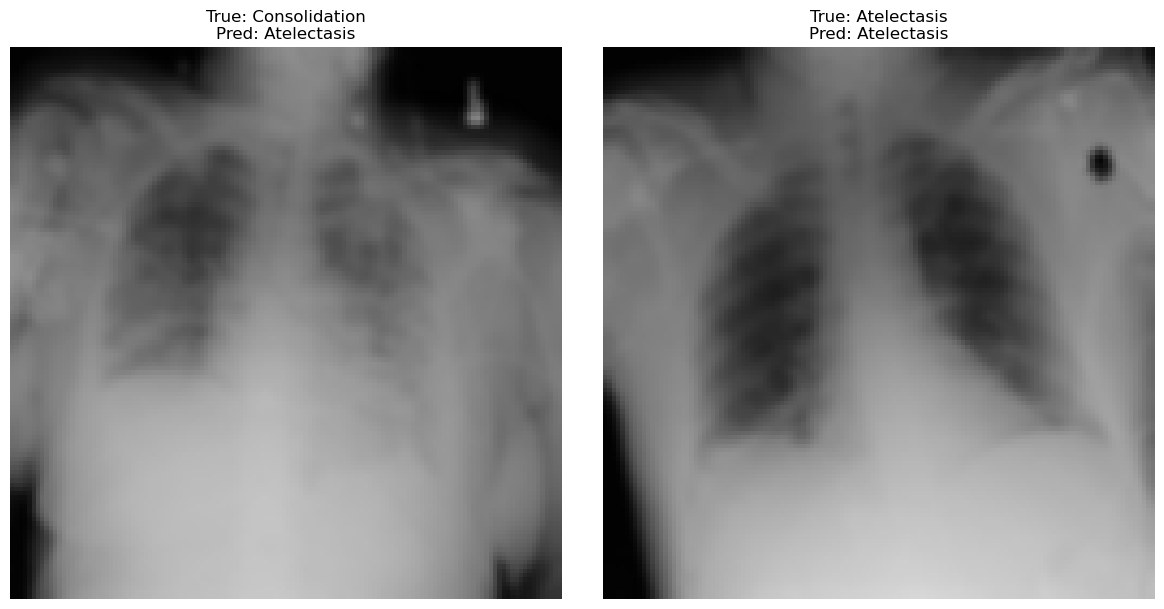

In [33]:
# === STEP 9: Evaluate Final Test Accuracy ===
loss, acc = model.evaluate(val_aug.flow(X_test, y_test), verbose=1)
print(f"[RESULT] Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")


# test on actual test set, show via matplotlib 2 images
def show_test_images(X, y, model, num_images=2):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = np.argmax(y[idx])
        pred_label = np.argmax(model.predict(np.expand_dims(img, axis=0)))
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {target_classes[true_label]}\nPred: {target_classes[pred_label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


show_test_images(X_test, y_test, model, num_images=2)

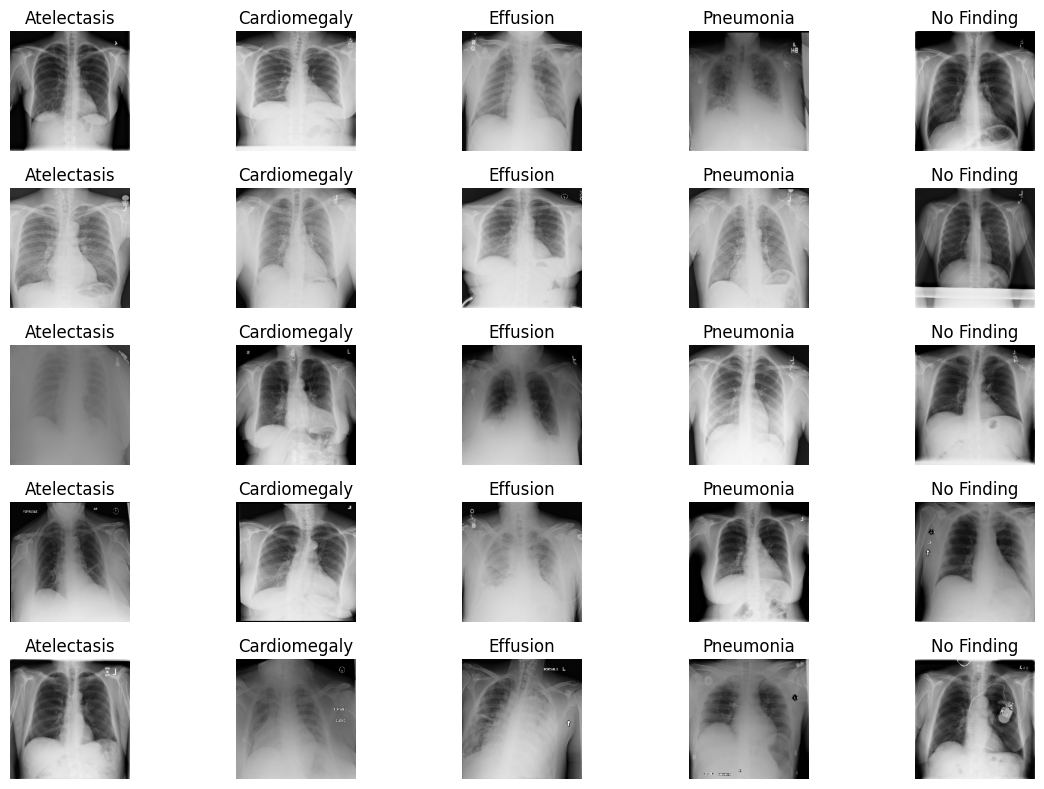

In [ ]:
# show 5 images of each type in the test set
def show_test_samples(df, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i, cls in enumerate(target_classes):
        sample = df[df['Finding Labels'] == cls].sample(num_samples)
        for j, (_, row) in enumerate(sample.iterrows()):
            img_path = find_image_path(row['Image Index'], DATA_DIR)
            if img_path:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                plt.subplot(num_samples, len(target_classes), j * len(target_classes) + i + 1)
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.title(cls)
                plt.axis('off')
    plt.tight_layout()
    plt.show()

show_test_samples(df_balanced, num_samples=5)


In [4]:
# test if tensorflow working
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))
a = torch.rand(5000, 5000).cuda()
b = torch.mm(a, a)
print("Done matrix multiplication on GPU.")

CUDA available: True
GPU Name: NVIDIA GeForce GTX 1650 with Max-Q Design
Done matrix multiplication on GPU.


In [ ]:
### Train/Validation/Test Split
from sklearn.model_selection import train_test_split

# 80% train, 10% val, 10% test
train_df, test_df = train_test_split(df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['Finding Labels'])

train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['Finding Labels'], random_state=42)

### DEBUG: Display the splits and percentages
print("\nDataset splits:")
print(f"Train samples: {len(train_df)}, {len(train_df)/len(df_balanced)*100:.2f}%")
print(f"Validation samples: {len(val_df)}, {len(val_df)/len(df_balanced)*100:.2f}%")
print(f"Test samples: {len(test_df)}, {len(test_df)/len(df_balanced)*100:.2f}%")
# Display pixel dimensions (width x height) for a few images in the dataset
print("\nSample image dimensions (pixels):")
for idx, row in df_balanced.head(5).iterrows():
    width = row['OriginalImage[Width']
    height = row['Height]']
    print(f"{row['Image Index']}: {width}x{height}")

### DEBUG: Display class distribution in each split
print("\nClass distribution in splits:")
print("Train:\n", train_df['Finding Labels'].value_counts())
print("Validation:\n", val_df['Finding Labels'].value_counts())
print("Test:\n", test_df['Finding Labels'].value_counts())



Dataset splits:
Train samples: 1159, 71.99%
Validation samples: 129, 8.01%
Test samples: 322, 20.00%

Sample image dimensions (pixels):
00015468_000.png: 2992x2991
00008051_006.png: 2500x2048
00028628_006.png: 1767x2021
00000618_000.png: 2596x2364
00020773_003.png: 2578x2991

Class distribution in splits:
Train:
 Finding Labels
Pneumonia       232
No Finding      232
Effusion        232
Cardiomegaly    232
Atelectasis     231
Name: count, dtype: int64
Validation:
 Finding Labels
Cardiomegaly    26
Pneumonia       26
Effusion        26
Atelectasis     26
No Finding      25
Name: count, dtype: int64
Test:
 Finding Labels
Atelectasis     65
No Finding      65
Cardiomegaly    64
Effusion        64
Pneumonia       64
Name: count, dtype: int64
